In [1]:
with open("lspd.txt", 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
print("Length", len(text))

Length 119161


In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print("Vocab Size", vocab_size)


 !,.:;?ँंःअआइईउऊऋएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहािीुूृेैोौ्ॐ।‍–‘’“”
Vocab Size 74


### Character Level Tokenizer

In [7]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] #encoder: takes string, output list of integers
decode = lambda l: "".join([itos[i] for i in l]) #decoder: takes the list of integers, output a string

In [8]:
print(encode("जरुर साथी म पागल"))
print(decode(encode("जरुर साथी म पागल")))

[29, 48, 58, 48, 1, 53, 55, 38, 57, 1, 46, 1, 42, 55, 24, 49]
जरुर साथी म पागल


Sentence Piece -> Subword
OpenAI -> tiktoken (GPT uses)

In [40]:
!pip install tiktoken

In [114]:
import tiktoken

In [115]:
enc = tiktoken.get_encoding("gpt2")
enc.n_vocab

50257

In [116]:
enc.encode("Joe")

[19585]

In [117]:
enc.encode("पागल")

[11976, 103, 48077, 11976, 245, 11976, 110]

In [118]:
enc.decode([11976, 103, 48077, 11976, 245, 11976, 110])

'पागल'

In [9]:
# Encode entire text dataset and store it in torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([119161]) torch.int64
tensor([41, 28, 55, 34, 57,  1, 29, 55, 41, 63, 53, 65,  1, 54, 61,  1, 46, 61,
        48, 55,  1, 42, 65, 48, 55, 36,  1,  2,  1, 11, 22, 61, 49, 57,  1, 46,
        49, 55, 14,  3,  0, 46, 41, 22, 63,  1, 50, 41, 46, 55,  1, 41, 41, 56,
        45, 65, 41, 61,  1, 24, 48, 57,  1, 50, 56, 48, 54,  1, 29, 49, 55, 14,
         1,  2,  0, 41, 41, 56, 45, 65, 41, 61,  1, 24, 48, 57,  1, 50, 56, 48,
        54,  1, 29, 49, 55, 14,  3,  0, 49, 63])


In [12]:
# Split data into train and validation sets
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
len(train_data)

107244

In [13]:
# We'll not feed entire text into the transformers at once. Computationally expensive.
# Work with chunks of data
# with Max Length, block_size
block_size = 8
train_data[:block_size+1]

tensor([41, 28, 55, 34, 57,  1, 29, 55, 41])

In [14]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"When input is {context}, target is: {target}")

When input is tensor([41]), target is: 28
When input is tensor([41, 28]), target is: 55
When input is tensor([41, 28, 55]), target is: 34
When input is tensor([41, 28, 55, 34]), target is: 57
When input is tensor([41, 28, 55, 34, 57]), target is: 1
When input is tensor([41, 28, 55, 34, 57,  1]), target is: 29
When input is tensor([41, 28, 55, 34, 57,  1, 29]), target is: 55
When input is tensor([41, 28, 55, 34, 57,  1, 29, 55]), target is: 41


In [15]:
# Batch Dimension
# Parallel Processing, Multiple chunks all at the same time.
torch.manual_seed(420)
batch_size = 4
block_size = 8

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
#     print(f"len(data): {len(data)}, block_size: {block_size}, batch_size: {batch_size}, len(data) - block_size: {len(data) - block_size}")
#     print(f"IX: {ix}")
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y

xb,yb = get_batch('train')
print("Inputs:")
print(xb.shape)
print(xb)
print("Targets:")
print(yb.shape)
print(yb)
print("------")


for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"When input is {context.tolist()}, target is: {target}")

Inputs:
torch.Size([4, 8])
tensor([[ 1,  2,  1, 41, 28, 58, 41, 59],
        [65, 24, 53, 65, 50, 55, 48, 65],
        [53, 65, 37, 62,  1, 28,  1, 46],
        [ 2,  0, 18, 22,  1, 37, 48, 26]])
Targets:
torch.Size([4, 8])
tensor([[ 2,  1, 41, 28, 58, 41, 59,  1],
        [24, 53, 65, 50, 55, 48, 65, 38],
        [65, 37, 62,  1, 28,  1, 46, 61],
        [ 0, 18, 22,  1, 37, 48, 26, 65]])
------
When input is [1], target is: 2
When input is [1, 2], target is: 1
When input is [1, 2, 1], target is: 41
When input is [1, 2, 1, 41], target is: 28
When input is [1, 2, 1, 41, 28], target is: 58
When input is [1, 2, 1, 41, 28, 58], target is: 41
When input is [1, 2, 1, 41, 28, 58, 41], target is: 59
When input is [1, 2, 1, 41, 28, 58, 41, 59], target is: 1
When input is [65], target is: 24
When input is [65, 24], target is: 53
When input is [65, 24, 53], target is: 65
When input is [65, 24, 53, 65], target is: 50
When input is [65, 24, 53, 65, 50], target is: 55
When input is [65, 24, 53, 65,

In [16]:
torch.randint(107236,(4,))

tensor([ 5547, 44831, 79558, 81261])

In [17]:
# We'll feed xb into the transformers, transformers will process the input and look upto yb for correct answers

In [19]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(420)

class BigramLanguageModel(nn.Module):
    '''
        It is simply a lookup table of logits for the next character given a previous character
    '''
    def __init__(self, vocab_size):
        super().__init__()
        # Each token directly reads off the logits for the next token from the lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        print("self.token_embedding_table", self.token_embedding_table)
        # print("Embedding Weights", self.token_embedding_table.weight[49])
        # print("Embedding Weights", self.token_embedding_table.weight[31])
        
    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensors of integers
        logits = self.token_embedding_table(idx) # B, T, C
        if targets is None:
            loss = None
        else:
            # Cross Entropy wants B, T, C. So,
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the prediction
            logits, loss = self(idx)
            # print("Logits", logits)
            # focus only on the last time step
            logits = logits[:, -1, :] # Becomes (B,C)
            # print("Logits", logits)
            # apply softmax to get the probabilities
            probs = F.softmax(logits, dim=-1)
            # print("Probs", probs)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # print("ID Next", idx_next)
            idx = torch.cat((idx, idx_next), dim = 1) # (B, T+1)
        return idx
    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

self.token_embedding_table Embedding(74, 74)
torch.Size([32, 74])
tensor(4.8599, grad_fn=<NllLossBackward0>)

लञअ’ढआखगप डऔ
ःशवऊै‘औई‘ल‍ठगःबपेः‍शई:ँिथह‘ःूूृयइय?.अओलढठबूक“ऊककखत?झधिमकथधच सटीरओपॐढँदऐ,‘?शोदअसण;ढ्घएअष


In [20]:
import torch.nn as nn
x = nn.Embedding(vocab_size, vocab_size)
x.weight

Parameter containing:
tensor([[ 1.7515, -0.9941, -0.6508,  ..., -0.5430, -0.0459,  0.2193],
        [ 0.4391, -0.9723,  1.0642,  ...,  0.4268, -0.2010,  0.7361],
        [-1.5503, -0.4205,  1.4080,  ...,  1.3648, -0.8378, -0.0643],
        ...,
        [ 0.8211, -1.3542,  0.7526,  ..., -0.7964,  0.8806,  0.4518],
        [ 0.7508,  0.3263, -1.6027,  ..., -0.1268,  0.4731, -0.9279],
        [-0.9792, -1.2182, -0.3756,  ...,  0.8577,  1.2365,  0.6499]],
       requires_grad=True)

In [21]:
emb = nn.Embedding(4,4)
print(emb.weight)
input = torch.LongTensor([[2]])
emb(input)

Parameter containing:
tensor([[-0.0472, -0.4430, -0.2003,  2.4293],
        [-0.7042, -1.3085,  1.0577, -0.7016],
        [ 1.0019, -0.4185, -0.8609, -1.4439],
        [-0.3811,  0.8902,  1.1004, -0.8110]], requires_grad=True)


tensor([[[ 1.0019, -0.4185, -0.8609, -1.4439]]], grad_fn=<EmbeddingBackward0>)

In [22]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [23]:
batch_size = 32
for steps in range(10000):
    xb, yb = get_batch('train')
    
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
print(loss.item())

2.5646562576293945


In [24]:
print(decode(m.generate(idx, max_new_tokens=300)[0].tolist()))


ने वाई तो,
प्क
 ला अम दिन्झन घरदछलारम इर्न गुको, ले भुकदछि भक !
फै  दुननान हायुनवशीबायो यङ्न्र गर्वी उस्ताहो झै मुला,
हिन्याँ उत्बा नी बसुभो ।
व्तिएको,
बनत् गहातिएकेरैं, लेँदनिन जहरी औँदाट?
चूत्विमर्छ,
कल गुनमदैओरुज्नकारी टुध रको,
मासङ्चिर !
जगडाल्दिनुसल्त्छनी बा चान्दिमुकलौं योसाहाबहा
आँ.ऊ प्काइ शब


We're only looking at the last character to predict the next.
Now, these tokens have to start talking to each other and figuring out what is in the context.
This is how we're going to kick-off Transformers.

The mathematical trick in self-attention

In [134]:
torch.manual_seed(420)
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

We have 8 tokens in a batch. They're currently not talking to each other.
Token at 5th location should not communicate with the token at 6th, 7th, 8th location.
Token at 5th location should only communicate with the token at 1st, 2nd, 3rd, 4th location.
Information flows from previous to next context.
What is the easiest way for tokens to communicate?
Average of all preceding elements. Weak & Lossy. That's ok for now.

In [135]:
# xbag_of_words = averaging
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        # For this batch, everything upto the tth token
        xprev = x[b, :t+1] #(t,C)
        # Averaging out the time
        xbow[b,t] = torch.mean(xprev, 0)
x[0]

tensor([[-0.0070,  0.5044],
        [ 0.6704, -0.3829],
        [ 0.0302,  0.3826],
        [-0.5131,  0.7104],
        [ 1.8092,  0.4352],
        [ 2.6453,  0.2654],
        [ 0.9235, -0.4376],
        [ 2.0182,  1.3498]])

In [61]:
xbow[0]

tensor([[-0.0070,  0.5044],
        [ 0.3317,  0.0608],
        [ 0.2312,  0.1681],
        [ 0.0451,  0.3037],
        [ 0.3979,  0.3300],
        [ 0.7725,  0.3192],
        [ 0.7941,  0.2111],
        [ 0.9471,  0.3534]])

This is very inefficient. The trick is to use Matrix Multiplication

In [136]:
torch.manual_seed(420)
a = torch.ones(3,3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a =')
print(a)
print('b =')
print(b)
print('c =')
print(c)

a =
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
b =
tensor([[1., 6.],
        [2., 7.],
        [5., 5.]])
c =
tensor([[ 8., 18.],
        [ 8., 18.],
        [ 8., 18.]])


In [137]:
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [138]:
torch.manual_seed(420)
a = torch.tril(torch.ones(3,3))
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a =')
print(a)
print('b =')
print(b)
print('c =')
print(c)

a =
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
b =
tensor([[1., 6.],
        [2., 7.],
        [5., 5.]])
c =
tensor([[ 1.,  6.],
        [ 3., 13.],
        [ 8., 18.]])


In [139]:
torch.manual_seed(420)
a = torch.tril(torch.ones(3,3))
a = a/torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a =')
print(a)
print('b =')
print(b)
print('c =')
print(c)

a =
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b =
tensor([[1., 6.],
        [2., 7.],
        [5., 5.]])
c =
tensor([[1.0000, 6.0000],
        [1.5000, 6.5000],
        [2.6667, 6.0000]])


In [140]:
# Version 2
wei = torch.tril(torch.ones(T,T))
wei = wei/wei.sum(1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [141]:
xbow2 = wei @ x # (B, T,T) @ (B, T, C) --> (B, T, C)
xbow2
torch.allclose(xbow, xbow2)

True

In [68]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
print("Wei: ", wei)
wei = wei.masked_fill(tril==0, float('-inf'))
print("Wei2: ", wei)
wei = F.softmax(wei, dim=-1)
print("Wei3: ", wei)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

Wei:  tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
Wei2:  tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
Wei3:  tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2

True

In [69]:
# version 4: self-attention basics
torch.manual_seed(420)
B,T,C = 4,8,32
x = torch.randn(B,T,C)
tril = torch.tril(torch.ones(T, T))

# These tokens will start looking at each other for affinities
wei = torch.zeros((T,T))
print("Wei: ", wei)

# Future can't communicate with the past
wei = wei.masked_fill(tril==0, float('-inf'))
print("Wei2: ", wei)
wei = F.softmax(wei, dim=-1)
print("Wei3: ", wei)
out = wei @ x

out.shape

Wei:  tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
Wei2:  tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
Wei3:  tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2

torch.Size([4, 8, 32])

We don't want
`wei = torch.zeros((T,T))`
to be all uniform. 
Different tokens will find more other tokens more or less interesting.
If I'm a vowel, maybe I'm looking for consonant in the past.
Maybe I want to know what those consonants are. I want that information to flow to me.
I want to gather information in the past. But, I want to do that in data-dependent way.

This is the problem, self-attention solves

Every single node or token at each position, emit two vectors (query, key)

query -> What am I looking for

key -> what do I contain

Dot product between keys and queries

My query dot products with all the keys of all the tokens. And the dot product becomes `wei`.

If key and query align, they'll yield high amount.

In [143]:
# self-attention
torch.manual_seed(420)
B,T,C = 4,8,32
x = torch.randn(B,T,C)
# let's see a single head of self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) -> (B, T, T)


tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
print("wei", wei[0])
wei = F.softmax(wei, dim=1)
v = value(x)
out = wei @ v
out.shape

wei tensor([[ 2.2728,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.5068, -0.5077,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.4327, -0.2557, -0.4741,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 1.3287, -2.1195, -2.6443, -0.4957,    -inf,    -inf,    -inf,    -inf],
        [ 0.4125, -1.2480, -3.1376, -0.5089, -2.1272,    -inf,    -inf,    -inf],
        [ 0.0485,  1.0301,  1.1512,  1.4882, -0.9631,  0.1086,    -inf,    -inf],
        [ 1.1692,  1.6438,  1.0493,  0.5698,  0.8746,  1.9510,  0.6115,    -inf],
        [-1.4170,  0.7859, -2.6072,  1.0348,  0.4087,  0.3289, -1.6117,  2.7514]],
       grad_fn=<SelectBackward0>)


torch.Size([4, 8, 16])

In [73]:
wei[0]

tensor([[0.4275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0731, 0.0504, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0679, 0.0648, 0.0912, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1663, 0.0100, 0.0104, 0.0596, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0665, 0.0240, 0.0064, 0.0588, 0.0271, 0.0000, 0.0000, 0.0000],
        [0.0462, 0.2343, 0.4631, 0.4333, 0.0867, 0.1168, 0.0000, 0.0000],
        [0.1418, 0.4329, 0.4182, 0.1729, 0.5445, 0.7375, 0.9023, 0.0000],
        [0.0107, 0.1836, 0.0108, 0.2753, 0.3417, 0.1456, 0.0977, 1.0000]],
       grad_fn=<SelectBackward0>)

In [108]:
out[0]

tensor([[ 6.0456e-01, -1.5550e-01,  2.0127e-01,  1.8277e-01, -5.1866e-03,
         -1.5409e-01,  9.9967e-02, -5.7802e-02, -8.7813e-02, -1.8669e-01,
         -2.4114e-02,  7.1841e-02, -2.6539e-01,  1.8791e-01,  1.1083e-01,
          4.5298e-01],
        [ 1.5799e-01, -1.0105e-03,  5.8079e-02,  4.8808e-02,  8.2898e-03,
          2.0822e-02,  4.1613e-02,  3.6835e-04, -1.0373e-02, -9.4940e-02,
          4.6224e-02, -1.4178e-02, -8.9967e-02,  6.3453e-02, -3.3155e-02,
          1.0161e-01],
        [ 2.4133e-01, -4.4916e-02, -8.9540e-03,  2.2071e-02, -6.1946e-03,
          1.6568e-01,  7.7308e-02, -4.1726e-02, -9.1936e-03, -1.4985e-01,
          1.1256e-01, -2.5931e-02, -9.1055e-02,  4.3798e-02, -1.1253e-01,
          3.1679e-02],
        [ 2.7880e-01, -2.2266e-02,  9.8550e-02,  1.0765e-01, -2.0372e-02,
          3.1448e-03,  7.8094e-02, -5.8466e-02, -2.9769e-02, -8.1342e-02,
         -1.4482e-02, -1.2349e-02, -1.0809e-01,  7.1086e-02,  3.2396e-02,
          1.8712e-01],
        [ 1.3364e-01

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [144]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1)

print(k.var())
print(q.var())
print(wei.var())

tensor(0.9264)
tensor(1.0146)
tensor(15.0543)


In [145]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1) * head_size**-0.5

print(k.var())
print(q.var())
print(wei.var())

tensor(1.0254)
tensor(0.9833)
tensor(1.0192)


In [146]:
sm = torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5]), dim=-1)
sm

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [147]:
lg = torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5])*16, dim=-1) # gets too peaky, converges to one-hot
lg

tensor([1.5939e-03, 1.3117e-05, 3.9102e-02, 1.3117e-05, 9.5928e-01])

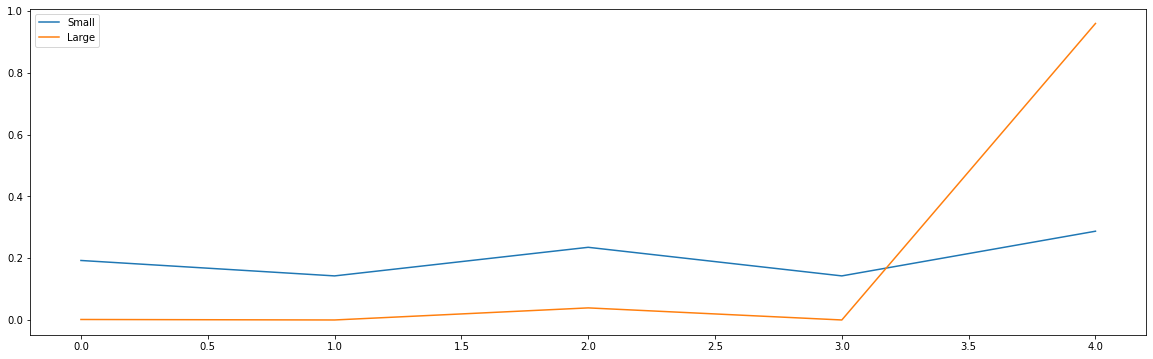

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.plot(sm, label="Small")
plt.plot(lg, label="Large")
plt.legend()
plt.show()